# Projeto 2 - Ciência dos Dados

Nome: Amanda Ades

Nome: Beni Kracochansky

Nome: Gabriel Kabbani

Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
# Classificador automático de sentimento


Para a análise deste projeto usaremos o Teorema de Bayes com a finalidade de estudar como as pessoas reagem conforme um determinado produto escolhido. No caso, iremos escolher um tópico (Tesla) e puxar uma quantidade de tweets do Twitter, criando assim um database em uma planilha. Uma quantidade de tweets serviram para o treinamento e estabilização do database enquanto o resto foi para o teste final. Ao que foram puxados os tweets, foi feito, manualmente, uma categorização dos tweets em três categorias: "Elogios", "Críticas" e "Irrelevantes". Após a categorização ser feita, passamos a limpar o database, tirando os tweets repetidos (aqueles que apresentavam 'rt') e outros caracteres indesejáveis presentes no código.

Após isso, através dos métodos de categorização, foi possível selecionar apenas os tweets relevantes ao projeto (tirando os repetidos e indesejáveis) e assim partindo para o classificador Naïve Bayes. Nele foi feita a categorização e montada uma tabela de ocorrência das palavras mais presentes nos tweets (através do .value_counts) e assim o grupo foi capaz de ter uma melhor noção de onde estavam situados os tweets e qual era a classificação das palavras. A tabela apresenta as palavras com o maior número de ocorrência de um lado e a quantidade dividida nas três categorias do outro.

A seguir, foi executada a parte matemática do código, onde foi aplicado o Teorema de Bayes. Entretando caso não fosse encontrada uma palavra no database de treinamento, foi aplicadio o conceito addidtivo de Laplace, resolvendo o problema de não ter uma referência. Passando por este obstáculo, seguiu-se o caminho aplicando o Teorema de Bayes normalmente com as variáveis já categorizadas e divididas.

Ademais, foi posto o classificador em prática para ver o quão eficiente e exato este era de acordo com o seu treinamento. Os resultados estão abaixo no código. Posteriormente, ainda se aplicou um código onde era criado uma espécie de "servidor", onde o código é um loop que pega 200 tweets em uma hora e re-classifica eles utilizando o classificador previamente feito.

Primeiramente, gostariamos de explicitar que durante a nossa análise, os números "0,1,2" representam, respectivamente, elogios, críticas, e irrelevantes.

## Preparando o ambiente no jupyter:

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

In [ ]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle
from time import sleep
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re

___
## Autenticando no  Twitter

* Conta: ***[@2Insper]***

In [3]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Etapas do projeto:

### Escolha de um produto e coleta das mensagens


In [4]:
#Produto escolhido:
produto = 'Tesla'

#aumentamos a quantidade de mensagens devido a quantidade de retweets.
#Quantidade mínima de mensagens capturadas:
n = 950
#Quantidade mínima de mensagens para a base de treinamento:
t = 600

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [5]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():    
    msgs.append(msg.full_text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [6]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

In [7]:
tweets= pd.ExcelFile('Tesla.xlsx')
treino= pd.read_excel(tweets, sheet_name='Treinamento')
teste= pd.read_excel(tweets, sheet_name='Teste')

___
### Classificando as mensagens na coragem

Esta etapa é manual. Faça a mesma pelo Excel.

**Propôs outras limpezas e transformações que não afetem a qualidade da informação

No código a seguir foi feita a limpeza da base de dados, isto é, a exclusão de retweets e caracteres que não são desejadas no treinamento. Algo que foi feito foi a exclusão do prefixo 'https//', para não serem contados links no database. Algo que poderia melhorar seria achar outro padrão em todos tweets de emojis, por exemplo, se o emoji for de risada, mostrar ao classificador como o resto do tweet pode ser impactado por tal, ou se for de tristeza, fazer o mesmo conforme for. Outra refinação no classificador poderia ser utilizar algo como ':)' rostinhos felizes como sinal de elogio e etc. 

In [ ]:
#Limpando a base de dados:

def limpador(tweet):
    retirar=[',',';','\n','...','......','***','.','-','|','?','!',':','[',']','(',')','"',"'",'&','#'] #verificar se faltam outros.
    tweet=str(tweet)
    tweet=re.sub(' +', ' ', tweet)
    tweet=tweet.split()
    lista=['@','https://']
    for i in tweet:
        i=i.lower()
    palavras=[]
    for palavra in tweet:
        if len(palavra)>0:
            if palavra[0]==lista[0]:
                pass
            if len(palavra)>7:
                if palavra[:8]==lista[1]:
                    pass
            else:
                for item in retirar:
                    palavra=palavra.strip(item)
                palavras.append(palavra)
    return " ".join(palavras)

tweets=[]
for tweet in treino['Treinamento']: #limpando todos os tweets da sheet 'Treinamento', e adicionando eles a uma lista.
        tweets.append(limpador(tweet))
for e in range (len(treino['Treinamento'])): #limpa o dataframe com os dados obtidos acima.
    if tweets[e][:2] == "rt": #removendo retweets.
        treino['Classificacao'][e]=3 #colocando um número diferente para que os retweets não sejam utilizados na analise. Destes, os @ não serão retirados, mas isso não impacta a análise pois não serão utilizados nela.
    else:
        treino['Treinamento'][e]=tweets[e]

___
### Montando o Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

**Propondo diferentes cenários para Naïve Bayes fora do contexto do projeto**

O algoritmo Naïve Bayes é um classificador baseado no Teorema de Bayes. Neste projeto, o classificador está sendo utilizado para machine-learning, ou seja, uma forma de treinamento para a máquina aprender e executar certas tarefas. No nosso caso, o classificador está sendo utilizado para categorizar e limpar os tweets extraídos do database. Os tweets foram primeiramente limpados, ou seja, foram excluídos retweets, isto é, tweets repetidos e também caracteres que possivelmente poderiam prejudicar a categorização como barras, pontos, asteriscos e etc. Já “limpos”, estes foram categorizados em “Elogios”, “Críticas” e “Irrelevantes”.

Fora do contexto do nosso trabalho, o algoritmo pode ser utilizado para identificar se algum e-mail é um SPAM ou a qual assunto este se refere. Outra possibilidade é de utilizar o algoritmo no diagnóstico de doenças e tomada de decisões sobre tratamentos. 


In [9]:
Elogios,Críticas,Irrelevantes,Retweets=treino['Classificacao'].value_counts()
Total=Elogios+Críticas+Irrelevantes

print('Total de elogios: {0}\nTotal de críticas: {1}\nTotal de irrelevantes: {2}\nTotal: {3}'.format(Elogios,Críticas,Irrelevantes,Total))

Total de elogios: 299
Total de críticas: 123
Total de irrelevantes: 94
Total: 516


In [10]:
E=treino[treino['Classificacao']==0]
C=treino[treino['Classificacao']==1]
I=treino[treino['Classificacao']==2]
palavras_separadas={}
i=0

for tipo in [E,C,I]: #separa as palavras de cada tipo de classificação em uma lista. Essa lista será o valor do nome do tipo de classificação no dicionário.
    if i==0:
        nome='Elogios'
    if i==1:
        nome='Críticas'
    if i==2:
        nome='Irrelevantes'
    lista=[]
    for tweet in tipo['Treinamento']:
        palavras=tweet.split()
        lista.extend(palavras)
    palavras_separadas[nome]=lista
    i+=1


palE=pd.DataFrame(data=palavras_separadas['Elogios'])
palE=palE[0].value_counts().to_frame()
palE.columns=['Número de Elogios']


palC=pd.DataFrame(data=palavras_separadas['Críticas'])
palC=palC[0].value_counts().to_frame()
palC.columns=['Número de Críticas']



palI=pd.DataFrame(data=palavras_separadas['Irrelevantes'])
palI=palI[0].value_counts().to_frame()
palI.columns=['Número de Irrelevantes']


pal=palE.join(palC, how='outer').fillna(0)
pal=pal.join(palI, how='outer').fillna(0)
pal.sort_values(by='Número de Irrelevantes', ascending=False).head()

,Número de Elogios,Número de Críticas,Número de Irrelevantes
tesla,105.0,80.0,200.0
o,44.0,21.0,141.0
de,54.0,45.0,138.0
a,60.0,28.0,136.0
e,38.0,29.0,129.0


In [11]:
def classificador(tweet):
    PE=pal['Número de Elogios']
    somaE=sum(PE)
    probE=1
    PC=pal['Número de Críticas']
    somaC=sum(PC)
    probC=1
    PI=pal['Número de Irrelevantes']
    somaI=sum(PI)
    probI=1
    tot=len(pal)
    
    for palavra in limpador(tweet):
        if palavra in pal.index:
            probE*=((PE[palavra]+1)/(somaE+tot)) #Laplace
            probC*=((PC[palavra]+1)/(somaC+tot))
            probI*=((PI[palavra]+1)/(somaI+tot))
        else:
            probE*=(1/(somaE+tot)) #Laplace
            probC*=(1/(somaC+tot))
            probI*=(1/(somaI+tot))
            
    probE*=(Elogios/Total)
    probC*=(Críticas/Total)
    probI*=(Irrelevantes/Total)
    
    probMax=0
    resultado=0
    
    for e in [probE,probC,probI]:
        if e==probE:
            a='0'#elogio
        if e==probC:
            a='1'#critica
        if e==probI:
            a='2'#irrelevante
        if e>probMax:
            probMax=e
            resultado=a
        
    
    return resultado

___
### Verificando a performance

Agora você deve testar o seu classificador com a base de Testes.

In [12]:
teste['Classificacao'].value_counts()

2    221
0     81
1     48
Name: Classificacao, dtype: int64

In [13]:
true_elogio=0
false_elogio=0
true_critica=0
false_critica=0
true_irrelevante=0
false_irrelevante=0

for e in teste.index:
    if int(classificador(limpador(teste['Teste'][e]))) == int(teste['Classificacao'][e]):
        if int(teste['Classificacao'][e])==0:
            true_elogio+=1
        elif int(teste['Classificacao'][e])==1:
            true_critica+=1
        elif int(teste['Classificacao'][e])==2:
            true_irrelevante+=1
    elif int(classificador(limpador(teste['Teste'][e]))) != int(teste['Classificacao'][e]):
        if int(classificador(teste['Teste'][e]))==0:
            false_elogio+=1
        elif int(classificador(teste['Teste'][e]))==1:
            false_critica+=1
        elif int(classificador(teste['Teste'][e]))==2:
            false_irrelevante+=1
            

totale=true_elogio+false_elogio
totalc=true_critica+false_critica
totali=true_irrelevante+false_irrelevante

FC=false_critica*100/totalc
FE=false_elogio*100/totale
FI=false_irrelevante*100/totali


print("Elogio verdadeiro:\nQuantidade:{0}\nPorcentagem do total de elogios:{1:.2f}%".format(true_elogio,true_elogio*100/totale))
print()
print()
print("Elogio falso:\nQuantidade:{0}\nPorcentagem do total de elogios:{1:.2f}%".format(false_elogio,FE))
print()
print()
print("Crítica verdadeira:\nQuantidade:{0}\nPorcentagem do total de críticas:{1:.2f}%".format(true_critica,true_critica*100/totalc))
print()
print()
print("Crítica falsa:\nQuantidade:{0}\nPorcentagem do total de críticas:{1:.2f}%".format(false_critica,FC))
print()
print()
print("Irrelevante verdadeiro:\nQuantidade:{0}\nPorcentagem do total de irrelevantes:{1:.2f}%".format(true_irrelevante,true_irrelevante*100/totali))
print()
print()
print("Irrelevante falso:\nQuantidade:{0}\nPorcentagem do total de irrelevantes:{1:.2f}%".format(false_irrelevante,FI))
print()
print('------------------------------------------------------')
print()
print("Porcentagem de erro do classificador: {0:.2f}%".format(FE/3+FC/3+FI/3))
print()
print("Porcentagem de acerto do classificador: {0:.2f}%".format(100-(FE/3+FC/3+FI/3)))

Elogio verdadeiro:
Quantidade:33
Porcentagem do total de elogios:21.15%


Elogio falso:
Quantidade:123
Porcentagem do total de elogios:78.85%


Crítica verdadeira:
Quantidade:11
Porcentagem do total de críticas:9.73%


Crítica falsa:
Quantidade:102
Porcentagem do total de críticas:90.27%


Irrelevante verdadeiro:
Quantidade:50
Porcentagem do total de irrelevantes:61.73%


Irrelevante falso:
Quantidade:31
Porcentagem do total de irrelevantes:38.27%

------------------------------------------------------

Porcentagem de erro do classificador: 69.13%

Porcentagem de acerto do classificador: 30.87%


Porcentagem de elogios, com relação ao total de tweets: 29.00%
Porcentagem de criticas, com relação ao total de tweets: 59.00%
Porcentagem de irrelevantes, com relação ao total de tweets: 12.00%


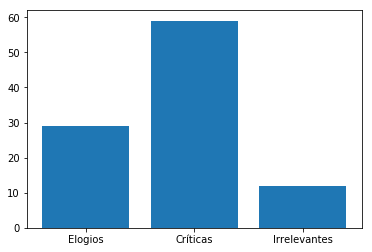

Porcentagem de elogios, com relação ao total de tweets: 29.50%
Porcentagem de criticas, com relação ao total de tweets: 57.00%
Porcentagem de irrelevantes, com relação ao total de tweets: 13.50%


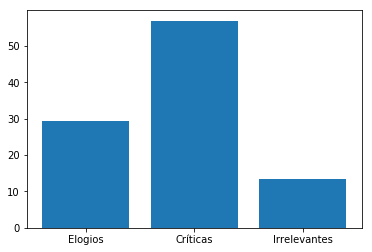

Porcentagem de elogios, com relação ao total de tweets: 30.00%
Porcentagem de criticas, com relação ao total de tweets: 55.00%
Porcentagem de irrelevantes, com relação ao total de tweets: 15.00%


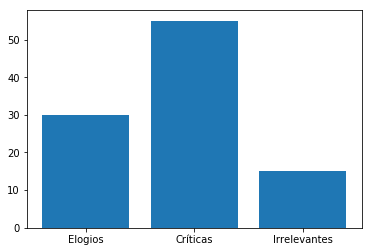

Porcentagem de elogios, com relação ao total de tweets: 33.00%
Porcentagem de criticas, com relação ao total de tweets: 48.00%
Porcentagem de irrelevantes, com relação ao total de tweets: 19.00%


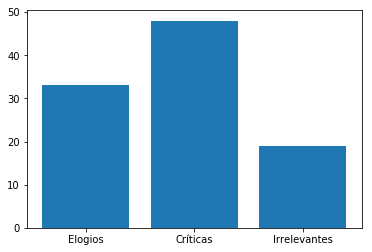

In [ ]:
api = tweepy.API(auth)
while (True):
    produto = 'Tesla'
    lang = 'pt'
    n=200
    i = 1
    msgs = []
    for msg in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():    
        msgs.append(msg.full_text.lower())
        i += 1
        if i > n:
            break
    shuffle(msgs)


    #Verifica se o arquivo não existe para não substituir um conjunto pronto
    live = pd.DataFrame({'Ao vivo' : pd.Series(msgs)})
    lista=[]
    for tweet in live['Ao vivo']:
        lista.append(int(classificador(limpador(tweet))))
    porcentagem_elogio=(lista.count(0))*100/len(lista)
    porcentagem_critica=(lista.count(1))*100/len(lista)
    porcentagem_irrelevante=(lista.count(2))*100/len(lista)
    
    print('Porcentagem de elogios, com relação ao total de tweets: {0:.2f}%'.format(porcentagem_elogio))
    print('Porcentagem de criticas, com relação ao total de tweets: {0:.2f}%'.format(porcentagem_critica))
    print('Porcentagem de irrelevantes, com relação ao total de tweets: {0:.2f}%'.format(porcentagem_irrelevante))
    
 

    x = [porcentagem_elogio,porcentagem_critica, porcentagem_irrelevante]
    bars = ('Elogios', 'Críticas', 'Irrelevantes')
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, x)
    plt.xticks(y_pos, bars)

    plt.show()

    sleep(60**2)



___
### Concluindo

Concluindo, o trabalho em questão quantitativa aparenta não apresentar problemas, ou seja, o grupo não teve dificuldades ou deixou de fazer algo quantitativamente. Os resultados estão disponibilizados no código, porém, em geral, o classificador acertou, em média 30% dos tweets, número que não é muito baixo dada a quantidade de tweets puxados. 

Porém, na parte qualitativa, ou na tomada de decisões o grupo identificou algo que possa gerar confusão. No classificador, como foram divididas em categorias de "Elogios" e "Críticas", certas palavras podem gerar confusão para a máquina. Por exemplo, como o classificador funciona por palavras, tweets que possuem um 'nao gosto', podem ser quebrados em 'nao' e 'gosto', podendo gerar uma confusão se é para se qualificar em elogios pela presença do 'gosto' ou no negativo por 'nao'. 

## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que periodicamente realiza análise de sentimento e visualiza estes dados

# Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**